In [45]:
from warnings import simplefilter

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import (
    EnsembleForecaster, 
    RecursiveRegressionForecaster,
    TransformedTargetForecaster,
)
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
# from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.performance_metrics.forecasting import sMAPE, smape_loss, MASE, mase_loss
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series

simplefilter("ignore", FutureWarning)
%matplotlib inline

In [2]:
raw_data = pd.read_csv('prices.csv')
raw_data.head()

,delivery_start_utc,delivery_end_utc,price
0,21.03.2021 22:00:00,21.03.2021 23:00:00,244.29
1,21.03.2021 21:00:00,21.03.2021 22:00:00,260.00
2,21.03.2021 20:00:00,21.03.2021 21:00:00,265.00
3,21.03.2021 19:00:00,21.03.2021 20:00:00,286.10
4,21.03.2021 18:00:00,21.03.2021 19:00:00,295.79


In [26]:
y = raw_data['price']
dates = pd.to_datetime(raw_data['delivery_start_utc'], format='%d.%m.%Y %H:%M:%S')
y.index = dates
y = y.sort_index()
y.index.freq = 'H'

y.head()

delivery_start_utc
2010-01-01 00:00:00    129.30
2010-01-01 01:00:00    110.17
2010-01-01 02:00:00    104.46
2010-01-01 03:00:00    105.00
2010-01-01 04:00:00    105.01
Freq: H, Name: price, dtype: float64

In [27]:
y.tail()

delivery_start_utc
2021-03-21 18:00:00    295.79
2021-03-21 19:00:00    286.10
2021-03-21 20:00:00    265.00
2021-03-21 21:00:00    260.00
2021-03-21 22:00:00    244.29
Freq: H, Name: price, dtype: float64

In [28]:
N_HOURS = 24
N_DAYS = 30

y_train, y_test = temporal_train_test_split(y, test_size=N_HOURS*N_DAYS)
print(f'y_train shape: {y_train.shape[0]}, y_test_shape: {y_test.shape[0]} ')

y_train shape: 97631, y_test_shape: 720 


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='price'>)

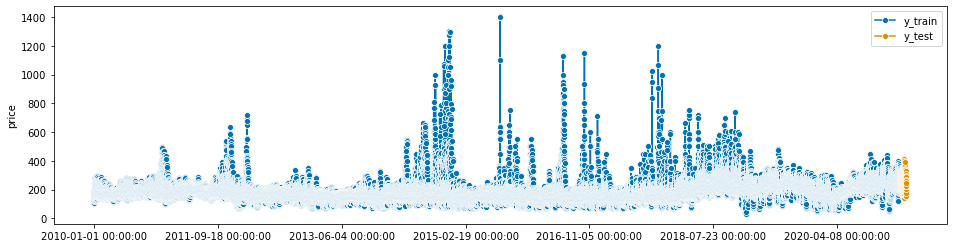

In [29]:
plot_series(y_train, y_test, labels=['y_train', 'y_test'])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='price'>)

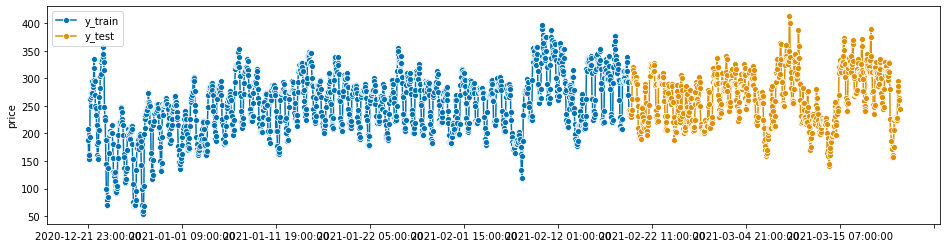

In [30]:
N_MONTHS = 2
plot_series(y_train.iloc[-N_MONTHS*N_DAYS*N_HOURS:], y_test, labels=['y_train', 'y_test'])

In [39]:
TRAIN_SAMPLE = 21*24 #21 days * 24 hours
TEST_SAMPLE = 7*24 #7 days * 24 hours

y_train_sample = y_train.iloc[-TRAIN_SAMPLE:]
y_test_sample = y_test.iloc[:TEST_SAMPLE]

42.147243590321594


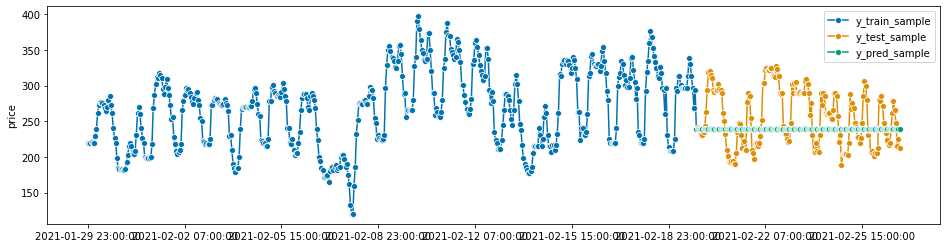

In [47]:
naive_forecaster = NaiveForecaster(strategy='last')
naive_forecaster.fit(y_train_sample)
fh_index = y_test_sample.index

fh = ForecastingHorizon(fh_index, is_relative=False)
y_pred_sample = naive_forecaster.predict(fh)
plot_series(y_train_sample, y_test_sample, y_pred_sample, 
            labels=['y_train_sample', 'y_test_sample', 'y_pred_sample'])

rmse = np.sqrt(mean_squared_error(y_true=y_test_sample, y_pred=y_pred_sample))
print(rmse)

39.17482426951803


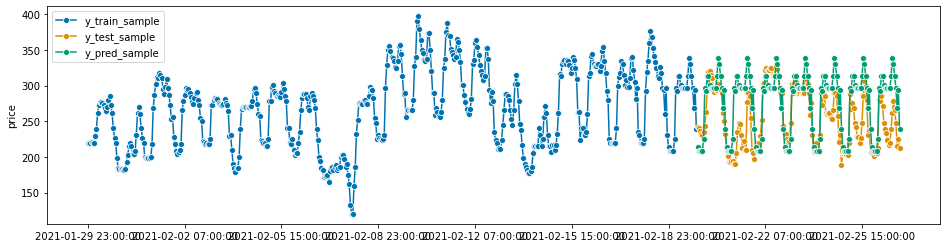

In [48]:
naive_forecaster = NaiveForecaster(strategy='last', sp=24)
naive_forecaster.fit(y_train_sample)
fh_index = y_test_sample.index

fh = ForecastingHorizon(fh_index, is_relative=False)
y_pred_sample = naive_forecaster.predict(fh)
plot_series(y_train_sample, y_test_sample, y_pred_sample, 
            labels=['y_train_sample', 'y_test_sample', 'y_pred_sample'])

rmse = np.sqrt(mean_squared_error(y_true=y_test_sample, y_pred=y_pred_sample))
print(rmse)

In [78]:
naive_forecasters = {
    'sp1_last': NaiveForecaster(strategy='last', sp=1),
    'sp1_mean_1': NaiveForecaster(strategy='mean', sp=1, window_length=24),
    'sp1_mean_2': NaiveForecaster(strategy='mean', sp=1, window_length=48),
    'sp1_mean_3': NaiveForecaster(strategy='mean', sp=1, window_length=72),
    'sp1_mean_4': NaiveForecaster(strategy='mean', sp=1, window_length=96),
    'sp1_mean_5': NaiveForecaster(strategy='mean', sp=1, window_length=120),
    'sp1_mean_6': NaiveForecaster(strategy='mean', sp=1, window_length=144),
    'sp1_mean_7': NaiveForecaster(strategy='mean', sp=1, window_length=168),
    'sp1_mean_all': NaiveForecaster(strategy='mean', sp=1, window_length=None),
    'sp24_last': NaiveForecaster(strategy='last', sp=24),
    'sp24_mean_1': NaiveForecaster(strategy='mean', sp=24, window_length=24),
    'sp24_mean_2': NaiveForecaster(strategy='mean', sp=24, window_length=48),
    'sp24_mean_3': NaiveForecaster(strategy='mean', sp=24, window_length=72),
    'sp24_mean_4': NaiveForecaster(strategy='mean', sp=24, window_length=96),
    'sp24_mean_5': NaiveForecaster(strategy='mean', sp=24, window_length=120),
    'sp24_mean_6': NaiveForecaster(strategy='mean', sp=24, window_length=144),
    'sp24_mean_7': NaiveForecaster(strategy='mean', sp=24, window_length=168),
    'sp24_mean_all': NaiveForecaster(strategy='mean', sp=24, window_length=None),
}

In [79]:
fh_index = y_test_sample.index
fh = ForecastingHorizon(fh_index, is_relative=False)
rmse_metrics = dict()
for naive_forecaster_name, naive_forecaster in naive_forecasters.items():
    naive_forecaster.fit(y_train_sample)
    y_pred_sample = naive_forecaster.predict(fh)
    rmse = np.sqrt(mean_squared_error(y_true=y_test_sample, y_pred=y_pred_sample))
    rmse_metrics[naive_forecaster_name] = rmse

In [80]:
rmse_metrics

{'sp1_last': 42.147243590321594,
 'sp1_mean_1': 45.163521409113216,
 'sp1_mean_2': 51.11715948600247,
 'sp1_mean_3': 50.88915106441204,
 'sp1_mean_4': 52.911520701918256,
 'sp1_mean_5': 53.1539864188406,
 'sp1_mean_6': 45.410950758666985,
 'sp1_mean_7': 43.83153026262819,
 'sp1_mean_all': 41.09021434968395,
 'sp24_last': 39.17482426951803,
 'sp24_mean_1': 39.17482426951803,
 'sp24_mean_2': 47.041765265723996,
 'sp24_mean_3': 46.02437964628526,
 'sp24_mean_4': 47.96963113080914,
 'sp24_mean_5': 48.51106852319278,
 'sp24_mean_6': 38.0715071107931,
 'sp24_mean_7': 35.49724644394323,
 'sp24_mean_all': 31.397264535674587}